In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import logit, mnlogit
from statsmodels.tools.tools import add_constant
from statsmodels.base.model import GenericLikelihoodModel

# Setting

In this problem, you will be working with some simulated data, roughly following the [Combined Logit Example](https://edstem.org/us/courses/61428/lessons/115899/slides/668804) in the lecture notes. **Choice** is the outcome value that can be 1, 2, or 3. The **income** covariate does not vary across options, while **price** does.

In [6]:
df = pd.read_csv("data.csv")
df

,income,price1,price2,price3,choice
0,0.408099,0.966943,0.745761,0.040999,2
1,0.053544,0.381934,0.584063,0.383261,3
2,0.420917,0.166761,0.711968,0.951595,1
3,0.393788,0.672119,0.273230,0.951942,1
4,0.043305,0.582327,0.387086,0.823542,1
...,...,...,...,...,...
995,0.188789,0.070250,0.165083,0.641672,3
996,0.493251,0.682945,0.476679,0.266091,1
997,0.352964,0.054450,0.665700,0.450901,2
998,0.274516,0.205258,0.958081,0.681329,1


# Part 1 [12 pts]

Estimate a combined logit model for this dataset, following the description in the lecture notes. Make option 3 the baseline option, and name the **five** parameters accordingly. Show the model summary.

In [23]:
class Combined_logit(GenericLikelihoodModel):
    def loglike(self, params):
        y, X = self.endog, self.exog 

        beta10, beta1, beta20, beta2, gamma = params
        y1 = beta10 + beta1 * X[:, 1] + gamma * X[:, 2]
        y2 = beta20 + beta2 * X[:, 1] + gamma * X[:, 3]
        y3 = gamma * X[:, 4]
        J = 3

        pij = np.empty((len(X), J))
        pij[:, 0] = np.exp(y1)
        pij[:, 1] = np.exp(y2)
        pij[:, 2] = np.exp(y3)
        pij /= np.sum(pij, axis=1, keepdims=True)

        #p1 = np.exp(y1) / (np.exp(y1) + np.exp(y2) + np.exp(y3))
        #p2 = np.exp(y2) / (np.exp(y1) + np.exp(y2) + np.exp(y3))
        #p3 = np.exp(y3) / (np.exp(y1) + np.exp(y2) + np.exp(y3))
        
        choices = y - 1
        likelihood = pij[np.arange(len(y)), choices]
        return np.sum(np.log(likelihood))

In [31]:
X = df[["income", "price1", "price2", "price3"]]
X = add_constant(X)
y = df["choice"]

Model = Combined_logit(y, X).fit(start_params=np.random.rand(5), method="bfgs")
Model.summary(xname=["b10","b1","b20","b2","g"])     

Optimization terminated successfully.
         Current function value: 1.091695
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Combined_logit Results                            
==============================================================================
Dep. Variable:                 choice   Log-Likelihood:                -1091.7
Model:                 Combined_logit   AIC:                             2193.
Method:            Maximum Likelihood   BIC:                             2218.
Date:                Mon, 21 Oct 2024                                         
Time:                        04:02:47                                         
No. Observations:                1000                                         
Df Residuals:                     995                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b10            0.1973      0.157      1.256      0.209      -0.111       0.505
b1            -0.6231      0.270     -2.305      0.021      -1.153      -0.093
b20            0.0997      0.159      0.626      0.532      -0.213       0.412
b2            -0.4688      0.272     -1.726      0.084      -1.001       0.063
g              0.2589      0.134      1.937      0.053      -0.003       0.521
==============================================================================
"""

# Part 2 [6 pts]

Briefly answer the following questions about the estimated parameters.

* Without consideration of the covariates (alternatively, consider setting them all to 0), rank the options from most likely to least likely. Which parameters give you this information, without having to explicitly compute probabilities?

* Suppose the **income** value increases by some amount while all **price**s remain unchanged. Rank the three options from largest to smallest increase (or largest decrease) in likelihood. Which parameters give you this information, without having to explicitly compute probabilities?

* Suppose the **price** value for option 3 increases by some amount while **income** and all *other* **price**s remain unchanged. How does this affect the likelihood of each option being chosen?

1. When consider covariates as 0, we have the formulas as:
   
   yi1 = b10 = 0.1974, yi2 = b20 = 0.0997	, yi3 = 0

   Thus we can see, from most likely to least likely, we have:

   Option 1, Option 2, Option 3. We gain this information mainly from b10 and b20.

2. With income increase andd prices unchanged, based on the formula, we have:
   
   Change of yi1: b1 * income = -0.6232 * income
   Change of yi2: b2 * income = -0.4687 * income
   Change of yi3: 0

   Thus we see decreases from largest to smallest as:
   
   Option 1, Option 2, Option 3. We gain this information mainly from b1 and b2.

3. For option 3 in the given situation, we have:
   
   Change of option 3: 0.2589	* price, as price increased, we have this change as positive. 

   Thuus, we have p of Option 3 increases. While at the same time, sum of all pij increases as while (but (pij for option 3)/sum(pij) would still be increasing), and as pij for option 1 and 2 remains unchanged, there likelihood would decrease.

# Part 3 [6 pts]

Let's see how the option probabilities vary as a function of **income**. Suppose all three **price**s are equal to $1$. Compute and plot all three option probabilities on one figure over the range of **income** from $-20$ to $20$ (pretend that negative income means something here).

Briefly describe your observations about the *shapes* of the probability curves. What does the (non-)motonocity of each curve tell you about how **income** affects the choice of each option?

In [36]:
incomes = np.linspace(-20, 20, 100)
params = Model.params
beta10, beta1, beta20, beta2, gamma = params
y1 = beta10 + beta1 * incomes + gamma
y2 = beta20 + beta2 * incomes + gamma
y3 = gamma

p1 = np.exp(y1) / (np.exp(y1) + np.exp(y2) + np.exp(y3))
p2 = np.exp(y2) / (np.exp(y1) + np.exp(y2) + np.exp(y3))
p3 = np.exp(y3) / (np.exp(y1) + np.exp(y2) + np.exp(y3))

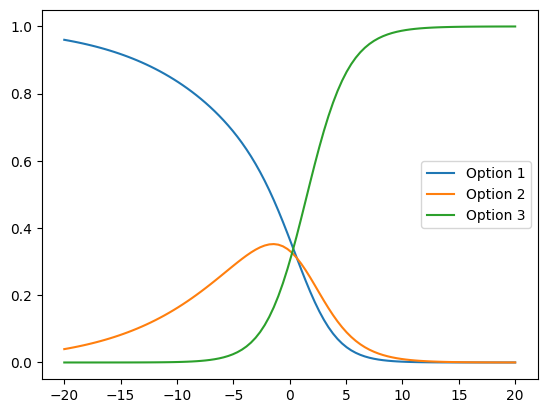

In [45]:
plt.plot(incomes, p1, label = "Option 1")
plt.plot(incomes, p2, label = "Option 2")
plt.plot(incomes, p3, label = "Option 3")
plt.legend()
plt.show()

We can see Option 3 benefits from increasing income the most, and Option 2 also benefits when the income increases while still negative, but then decreases when the income continues growing when it's positive, and Option 1 doesn't benefit from increasing income.

# Part 4 [6 pts]

Let's see how the option probabilities vary as a function of **price3**. Suppose all other covariates, including **income**, are equal to $1$. Compute and plot all three option probabilities on one figure over the range of **price3** from $-20$ to $20$.

Briefly describe your observations about the *shapes* of the probability curves. How would you expect the curve trends to change if either **price1** or **price2** varied instead of **price3**?

In [50]:
price3 = np.linspace(-20, 20, 100)
params = Model.params
beta10, beta1, beta20, beta2, gamma = params
y1 = beta10 + beta1 + gamma
y2 = beta20 + beta2 + gamma
y3 = gamma * price3

p1 = np.exp(y1) / (np.exp(y1) + np.exp(y2) + np.exp(y3))
p2 = np.exp(y2) / (np.exp(y1) + np.exp(y2) + np.exp(y3))
p3 = np.exp(y3) / (np.exp(y1) + np.exp(y2) + np.exp(y3))

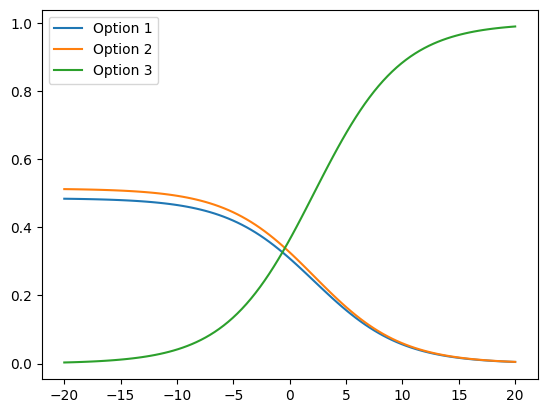

In [51]:
plt.plot(incomes, p1, label = "Option 1")
plt.plot(incomes, p2, label = "Option 2")
plt.plot(incomes, p3, label = "Option 3")
plt.legend()
plt.show()

We can see Option 3 benefits from the increasing price 3 while Option 1 and 2 don't benefit from increasing price 3. If we change it to price 1 or 2 as increasing term, we probably would see Option 1 or 2 benefit from such increasing respectively. 